# Interior-Point: Barrier Method

The following is an implementation of the *barrier method* flavor of the interior-point method. An alternative (better) approach is the primal-dual interior-point method.

Consider the standard dual form of an LP:
$$
\begin{aligned}
& \underset{y\in\mathbb{R}^n}{\text{minimize}}
& & b^\top y \\
& \text{subject to}
& & A^\top y \le c \\
\end{aligned}
$$
with $A=\begin{bmatrix}a_1 & \dots & a_m\end{bmatrix}\in\mathbb{R}^{n\times m}$ and $c\in\mathbb{R}^m$.

The idea of the barrier method is to use an indicator function $I_Q$ which takes $\infty$ outside of the feasible region $Q$ and $0$ within the feasible region. Of course, this indicator function is non-differentiable, so we use an approximation with a self-concordant barrier function, $F_Q$. Then, the problem becomes
$$
\begin{aligned}
& \underset{y\in\mathbb{R}^n}{\text{minimize}}
& & f(y) = b^\top y + \mu F_Q(y),
\end{aligned}
$$
where $\mu$ starts large and then decreases so that the original ogjective is dominate (i.e., after we are in the feasible region). This is known as a homotopy-type algorithm.

Consider the barrier function $F_Q(y) = -\sum_{i=1}^m \log(c_i - a_i^\top y)$. This constrained problem can then be rewritten as the unconstrained problem
$$
\begin{aligned}
& \underset{y\in\mathbb{R}^n}{\text{minimize}}
& & \frac{1}{\mu} b^\top y -\sum_{i=1}^m \log(c_i - a_i^\top y)
\end{aligned}
$$


The gradient and Hessian of this new objective are:
$$
\begin{align}
\nabla f(y) &= \frac{1}{\mu}b + \sum_{i=1}^m(c_i-a_i^\top y)^{-1} a_i
= \frac{1}{\mu}b + A
\begin{bmatrix}(c_1-a_1^\top x)^{-1}\\\vdots\\(c_m-a_m^\top y)^{-1}\end{bmatrix} \\
\nabla^2 f(y) &= \sum_{i=1}^m(c_i-a_i^\top y)^{-2} a_i a_i^\top
= A\,\text{diag}\begin{bmatrix}(c_1-a_1^\top x)^{-2}\\\vdots\\(c_m-a_m^\top x)^{-2}\end{bmatrix}A^\top
\end{align}
$$

In [1]:
%%capture
# Load Newton's method implementation from a previous notebook
%run newtons-method.ipynb

## Implementation

In [2]:
def barrier(x0, c, nu, F_Q, Fp_Q, Fpp_Q, N=1000):
    """Barrier Method
    x0: initial point, nx1 vector
    c: linear objective <c,x>, nx1 vector
    nu: complexity of barrier
    F_Q: barrier function, i.e., f(x) = <c,x> + μF_Q(x)
    Fp_Q: grad of barrier, nx1 -> nx1 (i.e., transpose of Jacobian)
    Fpp_Q: Hess of barrier, nx1 -> nxn
    N: number of steps
    """
    
    # problem dimensions
    n = len(c)
    
    # barrier
    M = 2 # Self-concordant with M=2
    
    # IP parameters
    beta = 1/10
    delta = 1.4/(1+10*np.sqrt(nu))
    
    # iterate history
    mu = np.zeros((N,))
    lam = np.zeros((N,))
    x = np.zeros((N,n))
    
    # initialization
    mu[0] = 1
    x[0, :] = x0
    
    for k in range(N-1):
        
        # gradient and Hessian of entire objective (we assume original objective is linear)
        fp = 1/mu[k] * c + Fp_Q(x[k, :])
        fpp = Fpp_Q(x[k, :])
                
        # Newton decrement
        lam[k] = np.sqrt( np.dot(np.linalg.solve(fpp,fp),fp) )
        
        if lam[k] > beta:
            # Not centered -- use damped Newton method
            mu[k+1] = mu[k]
            x[k+1, :] = x[k, :] - 1/(1+lam[k]) * np.linalg.solve(fpp,fp)
        else:
            mu[k+1] = mu[k]/(1+delta)
            fp = 1/mu[k+1] * c + Fp_Q(x[k, :])
            fpp = Fpp_Q(x[k, :])
            x[k+1, :] = x[k, :] - np.linalg.solve(fpp,fp)
            
    # optimal point and objective
    xopt = x[-1,:]
    fopt = c.T@xopt

    return fopt, xopt, x, mu, lam

## Example

Consider the LP defined by
$$
\begin{aligned}
& \underset{p(t)}{\text{minimize}}
& & \int_{-1}^1 p(t) dt \\
& \text{subject to}
& & p(t_i) \ge t_i \\
&&& t_i \in \{0, \frac{1}{r}, \dots, \frac{r-1}{r}, 1\}, i \in \{ 0, \dots, r \} \\
\end{aligned}
$$

where $p(t) = p_0 + p_1t^2 + p_2t^4$ and $r=50$. This can be written in the standard dual form with matrices

$$
\begin{align}
b^\top &= \begin{bmatrix}1 & \frac{1}{3} & \frac{1}{5}\end{bmatrix} \\
y^\top &= \begin{bmatrix}p_0 & p_1 & p_2\end{bmatrix} \\
c^\top &= \begin{bmatrix}0 & -t_1 & \dots & -t_r\end{bmatrix} \\
A^\top &=
\begin{bmatrix}
-1 & 0 & 0 \\
-1 & -t_1^2 & -t_1^4 \\
\vdots & \vdots & \vdots \\
-1 & -t_r^2 & -t_r^4 \\
\end{bmatrix}
\end{align}
$$

In [3]:
r = 50

t = np.arange(0, 1+1/r, 1/r)

# build problem data
b = np.array([1, 1/3, 1/5])
c = -t
A = np.array([-np.ones_like(t), -t**2, -t**4])

# dimensions
n = len(b)
m = len(c)

# polynomial eval
p = lambda y, t: y[0] + y[1]*t**2 + y[2]*t**4
pint = lambda y, t: y[0]*t + 1/3*y[1]*t**3 + 1/5*y[2]*t**5

In [4]:
def F_Q(y):
    """Logarithmic barrier function
    """
    return - np.log(c - A.T@y)

def Fp_Q(y):
    """Gradient of F_Q
    """
    d = (c - A.T@y)**(-1)
    return A @ d

def Fpp_Q(y):
    """Hessian of F_Q
    """
    d = (c - A.T@y)**(-2)
    return A @ np.diag(d) @ A.T

In [5]:
y0 = np.ones((n,))

fopt, yopt, y, mu, lam = barrier(y0, b, m, F_Q, Fp_Q, Fpp_Q, N=1000)

print(fopt)
print(yopt)

0.5392919861391082
[ 0.20323845  1.32525912 -0.52849751]


Text(0, 0.5, '$p(t)$')

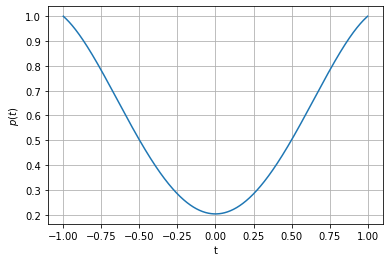

In [6]:
t = np.linspace(-1,1,1000)
plt.plot(t,p(yopt,t))
plt.grid()
plt.xlabel('t')
plt.ylabel('$p(t)$')

Text(0, 0.5, '$P(t)$')

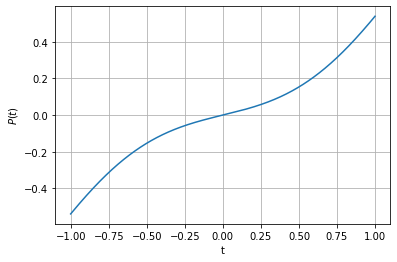

In [8]:
t = np.linspace(-1,1,1000)
plt.plot(t,pint(yopt,t))
plt.grid()
plt.xlabel('t')
plt.ylabel('$P(t)$')